# Using an external optimizer
Hazel comes with a preconfigured efficient Levenberg-Marquard algorithm, but it can also use any external optimizer. It can seamlessly integrate all SciPy optimizers but it also provides the tools to use other optimizers.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
from scipy.optimize import minimize, differential_evolution
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

2018.9.22


Let's start by generating a model by reading the following configuration file:

In [2]:
%cat conf_single.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 1

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Wavelength = 10826, 10833, 150
    Topology = ph1 -> ch1 -> te1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = 'observations/10830.wavelength'
    Wavelength weight file = 'observations/10830.weights'
    Observations file = 'observations/10830_stokes.1d'    
    Weights Stokes I = 1.0, 0.0, 0.0, 0.0
    Weights Stokes Q = 0.0, 0.0, 0.0, 0.0
    Weights Stokes U = 0.0, 0.0, 0.0, 0.0
    Weights Stokes V = 0.0, 0.0, 0.0, 0.0
    Mask

This is a very simple inversion in which only two variables are inverted. This is surely not realistic but serves for the purpose of showing how more complicated things can be done. Let's then read the configuration file and read the observation file defined in the configuration file.

In [ ]:
# Test a single inversion in non-iterator mode
mod = hazel.Model('conf_spot.ini', working_mode='inversion', verbose=2)
mod.read_observation()

Next, let us invert it with the Levenberg-Marquartd algorithm provided by Hazel:

In [4]:
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-05 13:15:04,949 - -------------
2018-10-05 13:15:04,950 -   Cycle 0  
2018-10-05 13:15:04,952 -   Weights for region spec1 : SI=1.0 - SQ=0.0 - SU=0.0 - SV=0.0
2018-10-05 13:15:04,953 - -------------
2018-10-05 13:15:04,955 - Free parameters for ph1
2018-10-05 13:15:04,957 -   - T with 1 node
2018-10-05 13:15:04,959 -   - vmic with 1 node
2018-10-05 13:15:05,270 - It: 0 - chi2: 111.73491265894616 - lambda: 0.01827468471342611 - rel: -1.9999999553060352
2018-10-05 13:15:05,437 - It: 1 - chi2: 94.9879533212469 - lambda: 0.004287504963923828 - rel: -0.1620232890860157
2018-10-05 13:15:05,540 - It: 2 - chi2: 94.9844932019989 - lambda: 0.09602514964800882 - rel: -3.642759054093184e-05


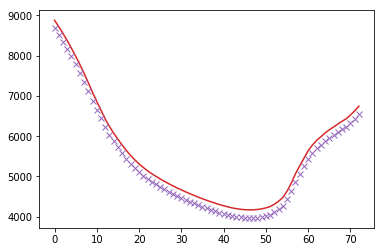

In [5]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

### Using SciPy

Then we open the output file, call `invert_external`, write the output and close it. `invert_external` allows the user to pass an SciPy optimizer and the arguments for the optimizer. The advantage of the SciPy optimizers is that they share the arguments. In this example, we'll use the Nelder-Mead algorithm, that does not use derivatives.

In [4]:
mod = hazel.Model('conf_spot.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert_external(minimize, method='Nelder-Mead')
mod.write_output()
mod.close_output()

2019-02-04 08:19:45,202 - Using configuration from file : conf_spot.ini
2019-02-04 08:19:45,219 - Backtracking mode : brent
2019-02-04 08:19:45,220 - Adding spectral region spec1
2019-02-04 08:19:45,221 -   - Reading wavelength axis from 10830_spot.wavelength
2019-02-04 08:19:45,237 -   - Reading wavelength weights from 10830_spot.weights
2019-02-04 08:19:45,242 -   - Using observations from 10830_spot.1d
2019-02-04 08:19:45,244 -   - No mask for pixels
2019-02-04 08:19:45,245 -   - No instrumental profile
2019-02-04 08:19:45,246 -   - Using LOS ['0.0', '0.0', '90.0']
2019-02-04 08:19:45,247 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2019-02-04 08:19:45,249 - Using 2 cycles
2019-02-04 08:19:45,250 - Not using randomizations
2019-02-04 08:19:45,251 - Adding atmospheres
2019-02-04 08:19:45,251 -   - New available chromosphere : ch1
2019-02-04 08:19:45,253 -     * Adding line : 10830
2019-02-04 08:19:45,254 -     * Magnetic field reference frame : vertical
2019-02-04 08:1

2019-02-04 08:20:07,754 - chi2: 2256.421231041984
2019-02-04 08:20:07,882 - chi2: 2288.2370961353063
2019-02-04 08:20:08,008 - chi2: 2348.744823424255
2019-02-04 08:20:08,138 - chi2: 2356.4340491217004
2019-02-04 08:20:08,393 - chi2: 2287.3121126777787
2019-02-04 08:20:08,649 - chi2: 2279.394620449786
2019-02-04 08:20:08,908 - chi2: 2277.218772609839
2019-02-04 08:20:09,164 - chi2: 2273.527730202047
2019-02-04 08:20:09,419 - chi2: 2262.919241044638
2019-02-04 08:20:09,547 - chi2: 2262.7418555533213
2019-02-04 08:20:09,806 - chi2: 2261.218896719727
2019-02-04 08:20:09,936 - chi2: 2273.75504163616
2019-02-04 08:20:10,064 - chi2: 2267.749157878059
2019-02-04 08:20:10,319 - chi2: 2258.589346607892
2019-02-04 08:20:10,572 - chi2: 2257.3466223028363
2019-02-04 08:20:10,831 - chi2: 2256.952372793815
2019-02-04 08:20:11,088 - chi2: 2254.2155138923135
2019-02-04 08:20:11,216 - chi2: 2256.194468166094
2019-02-04 08:20:11,469 - chi2: 2253.9256852259273
2019-02-04 08:20:11,721 - chi2: 2254.6061397

2019-02-04 08:20:36,568 - chi2: 1403.6187699124127
2019-02-04 08:20:36,706 - chi2: 1406.1259819422392
2019-02-04 08:20:36,843 - chi2: 1404.6611233726503
2019-02-04 08:20:36,979 - chi2: 1404.3477130776653
2019-02-04 08:20:37,240 - chi2: 1397.7588642804753
2019-02-04 08:20:37,368 - chi2: 1404.1152466328858
2019-02-04 08:20:37,622 - chi2: 1383.986977832511
2019-02-04 08:20:37,751 - chi2: 1390.4046178082333
2019-02-04 08:20:37,885 - chi2: 1385.7007303215435
2019-02-04 08:20:38,022 - chi2: 1385.2019238054063
2019-02-04 08:20:38,158 - chi2: 1384.5068792860463
2019-02-04 08:20:38,418 - chi2: 1370.9511052742714
2019-02-04 08:20:38,546 - chi2: 1376.4927906750481
2019-02-04 08:20:38,802 - chi2: 1357.82718743041
2019-02-04 08:20:38,936 - chi2: 1361.168355828214
2019-02-04 08:20:39,213 - chi2: 1337.8966833177008
2019-02-04 08:20:39,351 - chi2: 1348.3975012332578
2019-02-04 08:20:39,488 - chi2: 1342.3904131114277
2019-02-04 08:20:39,617 - chi2: 1340.940192841906
2019-02-04 08:20:39,869 - chi2: 1306

2019-02-04 08:21:09,040 - chi2: 241.13998252540316
2019-02-04 08:21:09,294 - chi2: 241.1378230288725
2019-02-04 08:21:09,420 - chi2: 241.1395124359746
2019-02-04 08:21:09,671 - chi2: 241.13902770826076
2019-02-04 08:21:09,929 - chi2: 241.13737469775205
2019-02-04 08:21:10,058 - chi2: 241.13756760595672
2019-02-04 08:21:10,310 - chi2: 241.13669043852815
2019-02-04 08:21:10,436 - chi2: 241.13604180614516
2019-02-04 08:21:10,688 - chi2: 241.13583555825912
2019-02-04 08:21:10,817 - chi2: 241.13600074746307
2019-02-04 08:21:10,943 - chi2: 241.13702797398804
2019-02-04 08:21:11,196 - chi2: 241.13188720098358
2019-02-04 08:21:11,322 - chi2: 241.1349312089291
2019-02-04 08:21:11,448 - chi2: 241.1361888771096
2019-02-04 08:21:11,574 - chi2: 241.13203760562865
2019-02-04 08:21:11,700 - chi2: 241.1337444870099
2019-02-04 08:21:11,826 - chi2: 241.1351079328758
2019-02-04 08:21:11,952 - chi2: 241.13340530320886
2019-02-04 08:21:12,078 - chi2: 241.13371557278012
2019-02-04 08:21:12,203 - chi2: 241.1

2019-02-04 08:21:36,333 - chi2: 222.1147950635844
2019-02-04 08:21:36,480 - chi2: 224.99458985641334
2019-02-04 08:21:36,627 - chi2: 224.7944209350066
2019-02-04 08:21:36,765 - chi2: 223.5960103023119
2019-02-04 08:21:36,898 - chi2: 224.5337840238621
2019-02-04 08:21:37,034 - chi2: 222.11522725171776
2019-02-04 08:21:37,167 - chi2: 222.26610995603988
2019-02-04 08:21:37,433 - chi2: 219.85161203639
2019-02-04 08:21:37,699 - chi2: 217.79576946336047
2019-02-04 08:21:37,832 - chi2: 218.10213888385746
2019-02-04 08:21:37,965 - chi2: 221.3183265679123
2019-02-04 08:21:38,099 - chi2: 218.57419475865717
2019-02-04 08:21:38,363 - chi2: 216.25337321189025
2019-02-04 08:21:38,497 - chi2: 218.6529748587505
2019-02-04 08:21:38,776 - chi2: 212.72190056682174
2019-02-04 08:21:38,913 - chi2: 214.2992787677393
2019-02-04 08:21:39,050 - chi2: 216.87147580234483
2019-02-04 08:21:39,188 - chi2: 216.44511913520313
2019-02-04 08:21:39,446 - chi2: 210.16110545764562
2019-02-04 08:21:39,576 - chi2: 211.60082

2019-02-04 08:22:07,454 - chi2: 103.040085702817
2019-02-04 08:22:07,713 - chi2: 103.03902688688413
2019-02-04 08:22:07,844 - chi2: 103.04184272637872
2019-02-04 08:22:07,974 - chi2: 103.04432418600743
2019-02-04 08:22:08,105 - chi2: 103.03916644875129
2019-02-04 08:22:08,363 - chi2: 103.032890620087
2019-02-04 08:22:08,491 - chi2: 103.0417626728884
2019-02-04 08:22:08,751 - chi2: 103.0256661799862
2019-02-04 08:22:09,008 - chi2: 103.03462321617444
2019-02-04 08:22:09,269 - chi2: 103.03430066307754
2019-02-04 08:22:09,398 - chi2: 103.03563741498331
2019-02-04 08:22:09,657 - chi2: 103.03305840694483
2019-02-04 08:22:09,945 - chi2: 103.01902045285374
2019-02-04 08:22:10,079 - chi2: 103.02841203368611
2019-02-04 08:22:10,382 - chi2: 103.03040863677447
2019-02-04 08:22:10,514 - chi2: 103.02130365712449
2019-02-04 08:22:10,643 - chi2: 103.02862970639801
2019-02-04 08:22:10,902 - chi2: 103.01325268256703
2019-02-04 08:22:11,160 - chi2: 103.00521702179881
2019-02-04 08:22:11,440 - chi2: 102.9

2019-02-04 08:22:36,559 - chi2: 56.55509593667306
2019-02-04 08:22:36,694 - chi2: 57.29010307470704
2019-02-04 08:22:36,826 - chi2: 57.556032493614936
2019-02-04 08:22:36,955 - chi2: 59.80724996467882
2019-02-04 08:22:37,086 - chi2: 57.70751133993255
2019-02-04 08:22:37,218 - chi2: 59.009078234655924
2019-02-04 08:22:37,349 - chi2: 58.671591424881036
2019-02-04 08:22:37,609 - chi2: 57.65359716723274
2019-02-04 08:22:37,868 - chi2: 57.56579157198641
2019-02-04 08:22:38,132 - chi2: 57.655977722869444
2019-02-04 08:22:38,267 - chi2: 58.68431364055948
2019-02-04 08:22:38,401 - chi2: 58.07908118318841
2019-02-04 08:22:38,676 - chi2: 57.04281964801222
2019-02-04 08:22:38,819 - chi2: 57.464422334237355
2019-02-04 08:22:39,100 - chi2: 56.761599649676626
2019-02-04 08:22:39,234 - chi2: 57.42570900487733
2019-02-04 08:22:39,393 - chi2: 57.29212263759513
2019-02-04 08:22:39,525 - chi2: 57.06002019611352
2019-02-04 08:22:39,788 - chi2: 57.22061809149107
2019-02-04 08:22:40,057 - chi2: 56.459012133

2019-02-04 08:23:09,835 - chi2: 55.74004143165118
2019-02-04 08:23:09,964 - chi2: 55.740093170932944
2019-02-04 08:23:10,091 - chi2: 55.73999327158574
2019-02-04 08:23:10,217 - chi2: 55.74003298015385
2019-02-04 08:23:10,344 - chi2: 55.73995798479237
2019-02-04 08:23:10,596 - chi2: 55.73996298336074
2019-02-04 08:23:11,976 - chi2: 55.739805308938195
2019-02-04 08:23:12,102 - chi2: 55.74000182387719
2019-02-04 08:23:12,358 - chi2: 55.74003537351903
2019-02-04 08:23:12,484 - chi2: 55.739816908592836
2019-02-04 08:23:12,610 - chi2: 55.740014744449624
2019-02-04 08:23:12,861 - chi2: 55.739858181176416
2019-02-04 08:23:13,113 - chi2: 55.739858399027426
2019-02-04 08:23:13,241 - chi2: 55.739856209687126
2019-02-04 08:23:14,622 - chi2: 55.73990057310571
2019-02-04 08:23:14,749 - chi2: 55.739969377692354
2019-02-04 08:23:14,876 - chi2: 55.73992103127619
2019-02-04 08:23:15,129 - chi2: 55.73996473636267
2019-02-04 08:23:15,383 - chi2: 55.73989125090201
2019-02-04 08:23:15,510 - chi2: 55.7397258

2019-02-04 08:23:55,302 - chi2: 12.778480823774974
2019-02-04 08:23:55,603 - chi2: 12.777853380681993
2019-02-04 08:23:55,756 - chi2: 12.778551461282525
2019-02-04 08:23:55,906 - chi2: 12.778386948776536
2019-02-04 08:23:56,206 - chi2: 12.776625758266245
2019-02-04 08:23:56,356 - chi2: 12.77704294956321
2019-02-04 08:23:56,506 - chi2: 12.777022533716867
2019-02-04 08:23:56,807 - chi2: 12.774285789321915
2019-02-04 08:23:56,956 - chi2: 12.774751773280805
2019-02-04 08:23:57,106 - chi2: 12.774567765340482
2019-02-04 08:23:57,413 - chi2: 12.771073984133327
2019-02-04 08:23:57,713 - chi2: 12.767699308006502
2019-02-04 08:23:57,865 - chi2: 12.768862955091306
2019-02-04 08:23:58,017 - chi2: 12.768028980499803
2019-02-04 08:23:58,318 - chi2: 12.758079393747787
2019-02-04 08:23:58,468 - chi2: 12.760258681229493
2019-02-04 08:23:58,618 - chi2: 12.758405720151254
2019-02-04 08:23:58,918 - chi2: 12.750313213128376
2019-02-04 08:23:59,219 - chi2: 12.737403125757707
2019-02-04 08:23:59,370 - chi2: 

Now we plot the results.

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


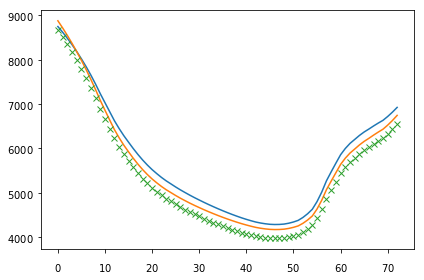

In [16]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

Now let's use an optimizer that uses first-order derivatives. Let's select the Newton-CG method:

In [17]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert_external(minimize, use_jacobian=True, method='Newton-CG')
mod.write_output()
mod.close_output()

2018-07-10 16:50:45,019 - Adding spectral region spec1
2018-07-10 16:50:45,021 -   - Reading wavelength axis from observations/10830.wavelength
2018-07-10 16:50:45,027 -   - Reading wavelength weights from observations/10830.weights
2018-07-10 16:50:45,034 -   - Using observations from observations/10830_stokes.1d
2018-07-10 16:50:45,036 -   - No mask for pixels
2018-07-10 16:50:45,038 -   - Using LOS ['0.0', '0.0', '90.0']
2018-07-10 16:50:45,039 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-07-10 16:50:45,041 - Using 1 cycles
2018-07-10 16:50:45,043 - Adding atmospheres
2018-07-10 16:50:45,045 -   - New available photosphere : ph1
2018-07-10 16:50:45,046 -     * Adding line : [300]
2018-07-10 16:50:45,048 -     * Magnetic field reference frame : vertical
2018-07-10 16:50:45,050 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-07-10 16:50:45,057 -   - New available chromosphere : ch1
2018-07-10 16:50:45,059 -     * Adding line : 10830

In [5]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()

OSError: photospheres/model_photosphere.1d not found.

### Using other external optimizers (pro-mode)
Using non-SciPy optimizers is slightly more complicated. For this purpose Hazel provides the necessary tools to use them. Here we show an example using the well-known Adam optimizer, broadly used for training deep neural networks. It is a first-order optimizer which uses derivative information. Let us first define a class that implements the Adam optimizer:

In [8]:
class AdamOptimizer:
    def __init__(self, fun, x0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0
        self.theta = x0
        self.fun = fun

    def optimize(self, n_iter):
        for i in range(n_iter):
            f, gradient = self.fun(self.theta)
            self.t = self.t + 1
            self.m = self.beta1*self.m + (1 - self.beta1)*gradient
            self.v = self.beta2*self.v + (1 - self.beta2)*(gradient**2)
            m_hat = self.m/(1 - self.beta1**self.t)
            v_hat = self.v/(1 - self.beta2**self.t)
            self.theta = self.theta - self.alpha*(m_hat/(np.sqrt(v_hat) - self.epsilon))
            print("Iter: {0} - chi2: {1}".format(self.t, f))
        return self.theta

Now we instantiate the model, read the observations and open the output. Next, we need to follow what `invert_external` does. First, compute some factors used internally by Hazel. Loop over all cycles with the following steps: i) find the active parameters, ii) instantiate the optimizer with the `_func_grad` function provided by Hazel, iii) call the optimizer, iv) set the final model and v) propagate the new parameters to the final ones. Finally, we write the output.

In [9]:
mod = hazel.Model('conf_single.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()

for k, v in mod.spectrum.items():
    v.factor_chi2 = 1.0 / (v.noise**2 * v.dof)

for mod.cycle in range(mod.n_cycles):
    mod.find_active_parameters(mod.cycle)
    n_pars = len(mod.nodes)
    
    optimizer = AdamOptimizer(mod._func_grad, mod.nodes)
    
    tmp = optimizer.optimize(300)
    
    mod.set_new_model(tmp)

    mod.flatten_parameters_to_reference(mod.cycle)
    
mod.write_output()
mod.close_output()

2018-10-05 13:15:27,266 - Adding spectral region spec1
2018-10-05 13:15:27,268 -   - Reading wavelength axis from observations/10830.wavelength
2018-10-05 13:15:27,271 -   - Reading wavelength weights from observations/10830.weights
2018-10-05 13:15:27,275 -   - Using observations from observations/10830_stokes.1d
2018-10-05 13:15:27,277 -   - No mask for pixels
2018-10-05 13:15:27,279 -   - No instrumental profile
2018-10-05 13:15:27,280 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-05 13:15:27,282 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-05 13:15:27,283 - Using 1 cycles
2018-10-05 13:15:27,285 - Not using randomizations
2018-10-05 13:15:27,290 - Adding atmospheres
2018-10-05 13:15:27,292 -   - New available photosphere : ph1
2018-10-05 13:15:27,294 -     * Adding line : [300]
2018-10-05 13:15:27,296 -     * Magnetic field reference frame : vertical
2018-10-05 13:15:27,301 -     * Reading 1D model photospheres/model_photosphere_200.1d as reference
2018-10-0

OSError: Unable to create file (unable to truncate a file which is already open)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


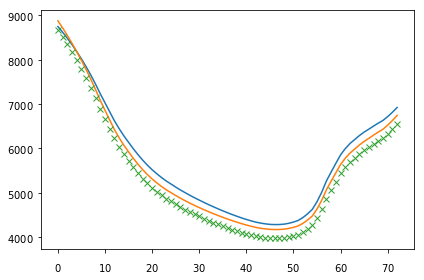

In [4]:
final = np.loadtxt('photospheres/model_photosphere.1d', skiprows=4)
start = np.loadtxt('photospheres/model_photosphere_200.1d', skiprows=4)
f = h5py.File('output.h5')
pl.plot(f['ph1']['T'][0,0,:])
pl.plot(final[:,1])
pl.plot(start[:,1], 'x')
f.close()